# Predicting Diagnosis from Clinical and Lifestyle Factors – Modeling Notebook

This notebook focuses on **data cleaning, preprocessing, and model building** for predicting the diagnostic category (`diagnosis`) using the dataset in `depression.csv`.

The exploratory data analysis (EDA), including detailed inspection of distributions, correlations, and relationships between features and the target, is performed in a separate notebook:

- `01_depression_eda.ipynb`

Here, we will:

1. Clean and preprocess the data for supervised learning.
2. Define a robust preprocessing pipeline (imputation, scaling, encoding).
3. Build and evaluate several classification models:
   - Baseline (most frequent class)
   - Multinomial Logistic Regression (with hyperparameter tuning)
   - Random Forest Classifier (with hyperparameter tuning)
4. Compare models side by side using multiple metrics.
5. Inspect feature importances from the best-performing model.


# 2. Import and Data Loading

In [8]:
# === 0. Imports and configuration ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from typing import List, Dict

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Plotting style
sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# Display options
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

RANDOM_STATE = 42
TARGET = "diagnosis"
DATA_PATH = "depression.csv"  # same folder as the EDA notebook

# === 1. Load data ===

df = pd.read_csv(DATA_PATH)

print("Data loaded successfully.")
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()


Data loaded successfully.
Shape: 1000 rows, 16 columns


,age,gender,sleep_quality_index,brain_fog_level,physical_pain_score,stress_level,depression_phq9_score,fatigue_severity_scale_score,pem_duration_hours,hours_of_sleep_per_night,pem_present,work_status,social_activity_level,exercise_frequency,meditation_or_mindfulness,diagnosis
0,56,Male,8.7,3.9,9.2,8.1,10.0,6.5,9.0,7.7,0,Working,Low,Daily,Yes,Depression
1,69,Male,1.3,9.9,4.2,9.9,20.0,7.0,41.0,8.4,1,Working,Low,Often,Yes,Both
2,46,Female,4.0,5.4,4.8,NaN,24.0,1.6,13.0,6.9,0,Partially working,NaN,Rarely,Yes,Depression
3,32,Female,9.4,2.1,2.9,3.8,10.0,6.8,11.0,7.5,0,Not working,High,Never,Yes,Depression
4,60,Female,7.6,7.5,6.4,8.5,17.0,7.0,46.0,3.1,1,Not working,Low,Rarely,No,Both


## Data Cleaning and Preprocessing Plan

We prepare the dataset for supervised learning with the following steps:

1. **Target definition**
   - Use `diagnosis` as the target variable.
   - Drop rows with missing `diagnosis` values, if any.

2. **Duplicate handling**
   - Identify and remove fully duplicated rows.

3. **Feature selection & leakage prevention**
   - Drop features derived directly from `diagnosis` to prevent label leakage (e.g., `has_depression_dx` if present).
   - Treat `depression_phq9_score` as an important numeric predictor, not as a target.

4. **Numeric vs categorical features**
   - Automatically identify numeric (`int`, `float`) and categorical (`object`, `category`) predictors.

5. **Missing values**
   - Numeric features: impute missing values with the **median**.
   - Categorical features: impute missing values with the **most frequent** category.

6. **Scaling and encoding**
   - Numeric features: standardized using `StandardScaler`.
   - Categorical features: one-hot encoded with `OneHotEncoder(handle_unknown="ignore")`.

7. **Train–test split**
   - Stratified split on `diagnosis` (e.g., 80% train, 20% test) to preserve class distribution.


In [9]:
# === 2. Data cleaning and preprocessing setup ===

# Work on a copy for modeling
model_df = df.copy()

# 1. Drop rows with missing target
initial_rows = model_df.shape[0]
model_df = model_df.dropna(subset=[TARGET])
dropped_target_missing = initial_rows - model_df.shape[0]
print(f"Dropped {dropped_target_missing} rows with missing target '{TARGET}'.")

# 2. Drop exact duplicate rows
n_duplicates = model_df.duplicated().sum()
if n_duplicates > 0:
    print(f"Dropping {n_duplicates} fully duplicated rows.")
    model_df = model_df.drop_duplicates()

print(f"Modeling DataFrame shape after cleaning: {model_df.shape}")

# 3. Prevent leakage: drop columns derived from diagnosis, if present
potential_leakage_cols = ["has_depression_dx"]  # created in EDA notebook
leakage_to_drop = [col for col in potential_leakage_cols if col in model_df.columns]

if leakage_to_drop:
    print(f"Dropping potential leakage columns: {leakage_to_drop}")
    model_df = model_df.drop(columns=leakage_to_drop)

# 4. Define features and target
X = model_df.drop(columns=[TARGET])
y = model_df[TARGET]

# 5. Identify numeric and categorical features
numeric_features: List[str] = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features: List[str] = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# 6. Preprocessing pipelines
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# 7. Train–test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nTraining target distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest target distribution:")
print(y_test.value_counts(normalize=True))


Dropped 0 rows with missing target 'diagnosis'.
Modeling DataFrame shape after cleaning: (1000, 16)
Numeric features: ['age', 'sleep_quality_index', 'brain_fog_level', 'physical_pain_score', 'stress_level', 'depression_phq9_score', 'fatigue_severity_scale_score', 'pem_duration_hours', 'hours_of_sleep_per_night', 'pem_present']
Categorical features: ['gender', 'work_status', 'social_activity_level', 'exercise_frequency', 'meditation_or_mindfulness']
Train shape: (800, 15)
Test shape: (200, 15)

Training target distribution:
diagnosis
Depression    0.40125
ME/CFS        0.39750
Both          0.20125
Name: proportion, dtype: float64

Test target distribution:
diagnosis
Depression    0.400
ME/CFS        0.395
Both          0.205
Name: proportion, dtype: float64


## Baseline and Modeling Approach

We now train and evaluate several models:

1. **Baseline** – `DummyClassifier` (most frequent class)  
   - Provides a minimal performance reference.

2. **Multinomial Logistic Regression** (with hyperparameter tuning)
   - Linear model with probabilistic outputs.
   - Tuned using `GridSearchCV` with stratified cross-validation and macro-averaged F1.

3. **Random Forest Classifier** (with hyperparameter tuning)
   - Non-linear, tree-based ensemble model.
   - Tuned using `GridSearchCV` and evaluated on macro-averaged F1.

We’ll compare all models on the held-out test set using:
- Accuracy
- Macro F1
- Weighted F1
- Macro Precision
- Macro Recall

Then we’ll inspect feature importances for the Random Forest model.


In [10]:
# === 3. Baseline model: DummyClassifier ===

baseline_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", DummyClassifier(strategy="most_frequent")),
    ]
)

baseline_clf.fit(X_train, y_train)
y_pred_baseline = baseline_clf.predict(X_test)

print("=== Baseline model: Most Frequent Class ===")
print(classification_report(y_test, y_pred_baseline, digits=3))


=== Baseline model: Most Frequent Class ===
              precision    recall  f1-score   support

        Both      0.000     0.000     0.000        41
  Depression      0.400     1.000     0.571        80
      ME/CFS      0.000     0.000     0.000        79

    accuracy                          0.400       200
   macro avg      0.133     0.333     0.190       200
weighted avg      0.160     0.400     0.229       200



Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Logistic Regression params: {'clf__C': 10.0, 'clf__penalty': 'l2'}
Best CV macro F1: 0.9747612295416976

=== Logistic Regression: Test set performance ===
              precision    recall  f1-score   support

        Both      0.974     0.902     0.937        41
  Depression      1.000     1.000     1.000        80
      ME/CFS      0.951     0.987     0.969        79

    accuracy                          0.975       200
   macro avg      0.975     0.963     0.969       200
weighted avg      0.975     0.975     0.975       200



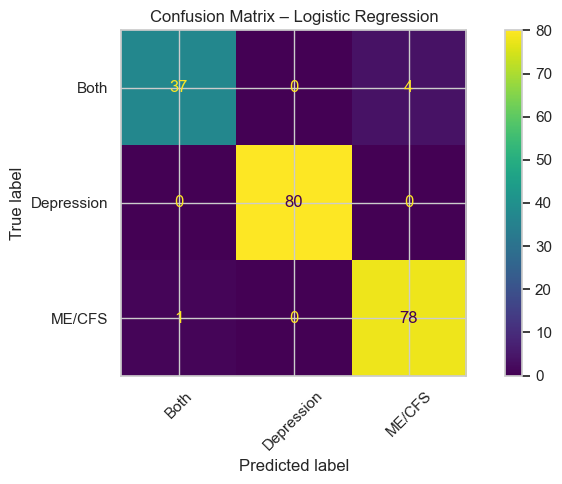

In [11]:
# === 4. Logistic Regression with hyperparameter tuning ===

log_reg_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        (
            "clf",
            LogisticRegression(
                solver="lbfgs",       # safe for most sklearn versions
                max_iter=1000,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

# Updated hyperparameter grid (do not specify multi_class)
log_reg_param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 10.0],
    "clf__penalty": ["l2"],
}

cv_strategy = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE,
)

log_reg_grid = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=log_reg_param_grid,
    cv=cv_strategy,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

log_reg_grid.fit(X_train, y_train)

print("Best Logistic Regression params:", log_reg_grid.best_params_)
print("Best CV macro F1:", log_reg_grid.best_score_)

best_log_reg = log_reg_grid.best_estimator_
y_pred_log = best_log_reg.predict(X_test)

print("\n=== Logistic Regression: Test set performance ===")
print(classification_report(y_test, y_pred_log, digits=3))

cm_log = confusion_matrix(y_test, y_pred_log, labels=best_log_reg.classes_)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=best_log_reg.classes_)
disp_log.plot(xticks_rotation=45)
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Random Forest params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best CV macro F1: 0.9892093552168824

=== Random Forest: Test set performance ===
              precision    recall  f1-score   support

        Both      0.976     1.000     0.988        41
  Depression      1.000     1.000     1.000        80
      ME/CFS      1.000     0.987     0.994        79

    accuracy                          0.995       200
   macro avg      0.992     0.996     0.994       200
weighted avg      0.995     0.995     0.995       200



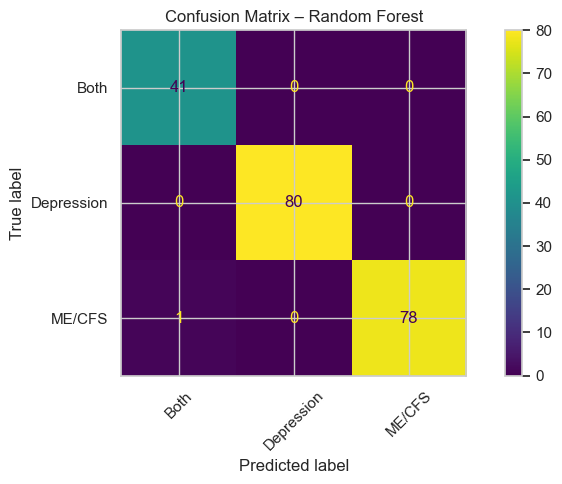

In [12]:
# === 5. Random Forest with hyperparameter tuning ===

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        (
            "clf",
            RandomForestClassifier(
                random_state=RANDOM_STATE,
                n_jobs=-1,
            ),
        ),
    ]
)

rf_param_grid = {
    "clf__n_estimators": [100, 300],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2"],
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=cv_strategy,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

rf_grid.fit(X_train, y_train)

print("Best Random Forest params:", rf_grid.best_params_)
print("Best CV macro F1:", rf_grid.best_score_)

best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("\n=== Random Forest: Test set performance ===")
print(classification_report(y_test, y_pred_rf, digits=3))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=best_rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=best_rf.classes_)
disp_rf.plot(xticks_rotation=45)
plt.title("Confusion Matrix – Random Forest")
plt.tight_layout()
plt.show()


Top 20 features by importance:


,feature,importance
5,depression_phq9_score,0.351930
9,pem_present,0.348379
6,fatigue_severity_scale_score,0.138540
2,brain_fog_level,0.020783
1,sleep_quality_index,0.018905
4,stress_level,0.017885
3,physical_pain_score,0.017206
8,hours_of_sleep_per_night,0.016482
7,pem_duration_hours,0.015580
0,age,0.013904


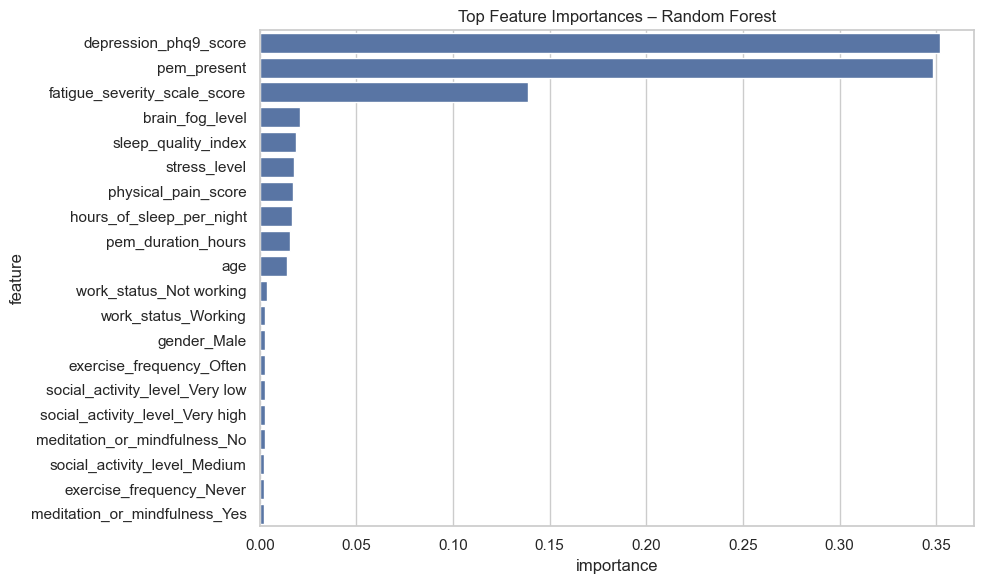

In [13]:
# === 6. Feature importance from best Random Forest ===

# Extract fitted preprocessor and RF model
fitted_preprocessor = best_rf.named_steps["preprocess"]
rf_model = best_rf.named_steps["clf"]

# Get feature names after preprocessing
numeric_feature_names = numeric_features

categorical_encoder = fitted_preprocessor.named_transformers_["cat"].named_steps["onehot"]
categorical_feature_names = categorical_encoder.get_feature_names_out(categorical_features).tolist()

all_feature_names = numeric_feature_names + categorical_feature_names

importances = rf_model.feature_importances_

feature_importance_df = (
    pd.DataFrame({"feature": all_feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

print("Top 20 features by importance:")
display(feature_importance_df.head(20))

# Plot top 20
top_n = 20
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df.head(top_n),
    x="importance",
    y="feature",
    ax=ax,
)
ax.set_title("Top Feature Importances – Random Forest")
plt.tight_layout()
plt.show()


## Model Comparison

We now compare all trained models side by side on the held-out test set using:

- Accuracy  
- Macro F1  
- Weighted F1  
- Macro Precision  
- Macro Recall  

Models:
- Baseline (Most Frequent Class)
- Logistic Regression (best hyperparameters from CV)
- Random Forest (best hyperparameters from CV)


In [14]:
# === 7. Model comparison table ===

def evaluate_model(name: str, y_true, y_pred) -> Dict[str, float]:
    """
    Compute a set of evaluation metrics for the given model.
    """
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro Recall": recall_score(y_true, y_pred, average="macro"),
    }

results = []
results.append(evaluate_model("Baseline (Most Frequent)", y_test, y_pred_baseline))
results.append(evaluate_model("Logistic Regression (Best CV)", y_test, y_pred_log))
results.append(evaluate_model("Random Forest (Best CV)", y_test, y_pred_rf))

comparison_df = pd.DataFrame(results)

print("=== MODEL PERFORMANCE COMPARISON (Test Set) ===")
display(comparison_df.sort_values("Macro F1", ascending=False))


=== MODEL PERFORMANCE COMPARISON (Test Set) ===


,Model,Accuracy,Macro F1,Weighted F1,Macro Precision,Macro Recall
2,Random Forest (Best CV),0.995,0.993861,0.995014,0.992063,0.995781
1,Logistic Regression (Best CV),0.975,0.968551,0.974758,0.974968,0.963260
0,Baseline (Most Frequent),0.400,0.190476,0.228571,0.133333,0.333333


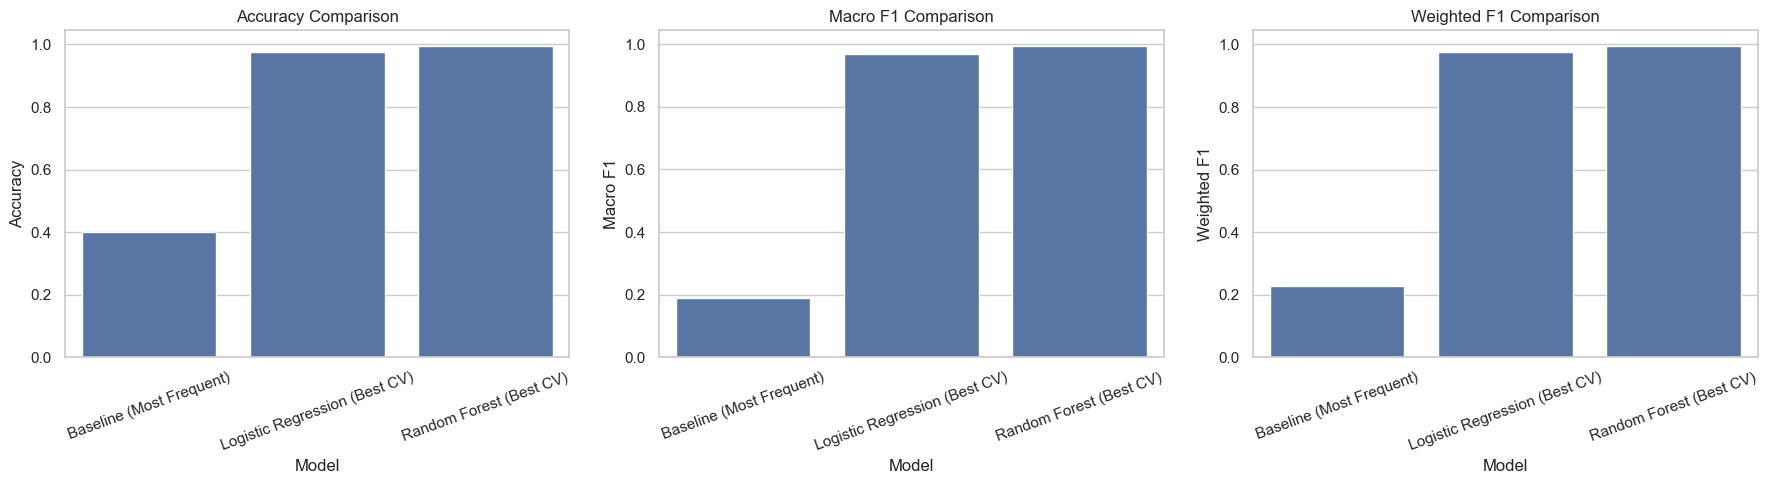

In [15]:
# === 8. Visual comparison of model performance ===

metrics_to_plot = ["Accuracy", "Macro F1", "Weighted F1"]

fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(18, 5))

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(
        data=comparison_df,
        x="Model",
        y=metric,
        ax=axes[i],
    )
    axes[i].set_title(metric + " Comparison")
    axes[i].tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()


## Interpretation and Next Steps

From the model comparison:

- Identify which model achieves the highest **Macro F1** and **Weighted F1**, as these metrics balance performance across classes and are less biased by any majority class.
- Compare the **Logistic Regression** and **Random Forest** models against the **Baseline** (most frequent class) to quantify how much value the learned models add over a naive strategy.
- Use the **Random Forest feature importances** to understand which clinical and lifestyle factors (for example, PHQ-9 score, sleep quality, fatigue, stress, PEM status) most strongly influence the predicted diagnosis.

A good practice is to:
- Prefer the model with the best **Macro F1** if you want balanced performance across all diagnostic categories.
- Cross-check that overall **Accuracy** and **Weighted F1** are also reasonable, especially if the classes are imbalanced.
- Use confusion matrices to see which classes are consistently misclassified and whether certain diagnoses are harder to predict.

**Potential next steps:**

- **Export the best-performing pipeline** using `joblib` so it can be reused in other notebooks, scripts, or a production service.
- **Add additional models**, such as Gradient Boosting, XGBoost, or LightGBM, and include them in the same comparison framework.
- Perform more advanced **hyperparameter tuning** (for example, randomized search, Bayesian optimization) to squeeze out further performance gains.
- Add **explainability tools** such as SHAP to obtain local and global explanations of model behavior and enhance clinical interpretability.


In [16]:
# === 9. Select best model and export it ===

import joblib

# Choose which metric to use for "best" model
metric_to_select = "Macro F1"

# Identify the best row in the comparison table
best_row = comparison_df.sort_values(metric_to_select, ascending=False).iloc[0]
best_model_name = best_row["Model"]

print(f"Best model based on {metric_to_select}: {best_model_name}")
print("Metrics for best model:")
display(best_row.to_frame().T)

# Map model names to the actual fitted estimators
model_registry = {
    "Baseline (Most Frequent)": baseline_clf,
    "Logistic Regression (Best CV)": best_log_reg,
    "Random Forest (Best CV)": best_rf,
}

best_pipeline = model_registry[best_model_name]

# Path for saving the model in the same folder as this notebook
MODEL_PATH = "best_diagnosis_model.joblib"

joblib.dump(best_pipeline, MODEL_PATH)
print(f"\nSaved best model pipeline to: {MODEL_PATH}")


Best model based on Macro F1: Random Forest (Best CV)
Metrics for best model:


,Model,Accuracy,Macro F1,Weighted F1,Macro Precision,Macro Recall
2,Random Forest (Best CV),0.995,0.993861,0.995014,0.992063,0.995781



Saved best model pipeline to: best_diagnosis_model.joblib


In [18]:
import joblib

MODEL_PATH = "best_diagnosis_model.pkl"

joblib.dump(best_pipeline, MODEL_PATH)

print(f"Best model saved successfully as: {MODEL_PATH}")


Best model saved successfully as: best_diagnosis_model.pkl


In [19]:
# === 10. Example: predict diagnosis for a new patient ===

# If running in a fresh session, you would reload like this:
# best_pipeline = joblib.load("best_diagnosis_model.joblib")

# Example input. Adjust field names and values to match your dataset's columns.
# Only include columns that actually exist in X (your feature set).
new_patient = {
    "age": 35,
    "gender": "Female",
    "depression_phq9_score": 15,
    "sleep_quality_index": 8,
    "brain_fog_level": 7,
    "physical_pain_score": 5,
    "stress_level": 8,
    "fatigue_severity_scale_score": 6,
    "pem_duration_hours": 12,
    "hours_of_sleep_per_night": 5,
    "work_status": "Employed full-time",
    "social_activity_level": "Low",
    "exercise_frequency": "Sometimes",
    "meditation_or_mindfulness": "No",
    "pem_present": 1,
    # If your dataset has additional feature columns, you can add them here.
}

# Convert the dict to a single-row DataFrame
new_patient_df = pd.DataFrame([new_patient])

# Make prediction
predicted_dx = best_pipeline.predict(new_patient_df)[0]
predicted_proba = best_pipeline.predict_proba(new_patient_df)[0]

print("Predicted diagnosis:", predicted_dx)

# Show class probabilities
print("\nPrediction probabilities:")
for cls, p in zip(best_pipeline.classes_, predicted_proba):
    print(f"  {cls}: {p:.3f}")


Predicted diagnosis: Both

Prediction probabilities:
  Both: 0.510
  Depression: 0.400
  ME/CFS: 0.090
